In [68]:
%matplotlib inline
import scipy.io as sio
import random
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
import cv2
from scipy.special import expit

In [69]:
a = sio.loadmat('ex5data1.mat')

#Training sets
y = a['y']
X = a['X'] 
print X.shape, y.shape

Xcv = a['Xval']
ycv = a['yval']
print Xcv.shape, ycv.shape

Xtest = a['Xtest']
ytest = a['ytest']

(12, 1) (12, 1)
(21, 1) (21, 1)


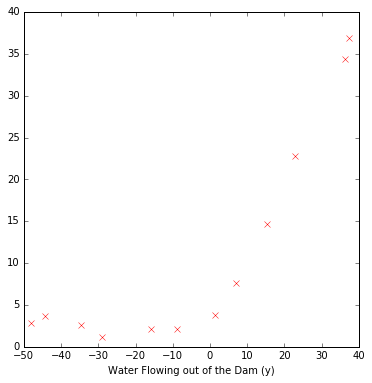

In [70]:
fig = plt.figure(figsize=(6,6))
plt.plot(X,y,'rx')
plt.xlabel('Change in Water Level (x)')
plt.xlabel('Water Flowing out of the Dam (y)')

In [71]:
X     = np.insert(X,0,1,axis=1)
Xcv   = np.insert(Xcv,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

In [72]:
def h(x,theta):
    return np.dot(x,theta) 

def computeCost(theta,x,y,lam=0.):

    reg = float(lam/(2*len(y)) * np.dot(theta[1:].T,theta[1:]))
    cost = 1./(2*len(y))* np.dot((h(x,theta).reshape((len(x),1)) - y ).T,
                                 (h(x,theta).reshape((len(x),1))-y))
   
    return float(cost + reg) 

In [73]:
theta = np.ones([2,1])
computeCost(theta,X,y,0.01)

303.9519422202643

In [74]:
#Remember, everything needs to be flatten. bleck
#Probably should have this written so that this funciton returns the 
#correctly shaped gradient, rather than flattened.
def computeGradient(theta,x,y,lam=0.):
    
    theta = theta.reshape((theta.shape[0],1))
    reg = float(lam)/len(y)*theta[1:]
    grad = 1./len(y)*np.dot(( h(x,theta) - y).T, x)         
    grad[0][1:] += reg[0]
    return grad.flatten() 

In [75]:
computeGradient(theta,X,y,1.)

array([ -15.30301567,  598.25074417])

In [76]:
# suggested fmincg exists in python! word
from scipy.optimize import fmin_cg

def optimizeParams(theta,x,y,lam=0.):
    #print "Length of params ", len(x)
    xopt = fmin_cg(computeCost, 
                   x0=theta,
                   fprime=computeGradient,
                   args=(x,y,lam),
                   maxiter=100,
                   disp=False,
                   full_output=True)
    
    return xopt

itheta = np.ones((X.shape[1],1)).reshape(-1)
param = optimizeParams(itheta,X,y,0.)

(-50, 50)

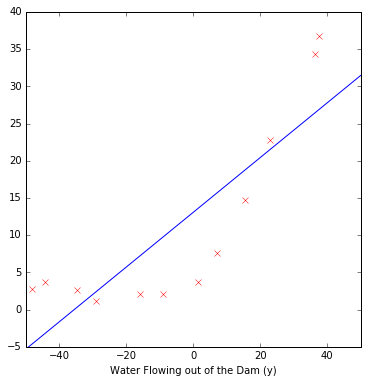

In [77]:
xit = np.linspace(-50,50,200)
yit = [ x *param[0][1] + param[0][0] for x in xit]

fig = plt.figure(figsize=(6,6))
plt.plot(X[:,1],y,'rx')
plt.plot(xit,yit,'b-')
plt.xlabel('Change in Water Level (x)')
plt.xlabel('Water Flowing out of the Dam (y)')
plt.ylim(-5,40)
plt.xlim(-50,50)

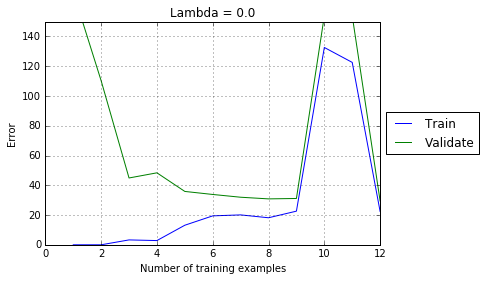

In [78]:
def getErrors(X,y,Xcv,ycv,lam=0.):
    
    error_train = []
    error_val = [] 
    itheta = np.ones([X.shape[1],1])
    
    #plt.figure()
    #plt.plot(X[:,1],y,'rx')

    for i in xrange(1,len(X)+1): 
        
        param_v = optimizeParams(itheta,X[:i],y[:i],lam)
        ftheta = param_v[0]
        
        error_train.append(param_v[1])
        error_val.append(computeCost(ftheta,Xcv,ycv,0))
  
        #y_test = [x*ftheta[1] + ftheta[0] for x in x_test]
        
        #if i > 6:
        #    plt.plot(x_test,y_test,label='For %i Training Ex'%i)

    xit = np.arange(1,len(X)+1).tolist()
    
    plt.figure()
    plt.plot(xit,error_train,'b-',label='Train')
    plt.plot(xit,error_val,'g-',label='Validate')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Lambda = %.1f'%lam)
    plt.ylim(0,150)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
 
    return error_train, error_val

#So. This plot looks a bit different than that of the example
#However, going back to the plot fits for variety of data counts,
#I confirm these errors are reflective of the quality of the fits. 
_,_ = getErrors(X,y,Xcv,ycv)

In [79]:
def getPolyX(X,poly):
    
    pow_v = np.array([i for i in xrange(poly+1)])
    X_new = X
    for p in xrange(2,poly+1):
        
        x_new = np.power(X[:,1],pow_v[p]).reshape([len(X),1])
        X_new = np.c_[X_new,x_new]
    
    return X_new

In [80]:
def featureNormalize(x):
    
    #poly-degree array of mean and std
    mean_v = np.mean(x,axis=0) 
    std_v = np.std(x,axis=0)
    
    x[:,1:] -= mean_v[1:]
    x[:,1:] /= std_v[1:]
    
    return x, mean_v, std_v 

In [81]:
polyX = getPolyX(X,8)
X_norm, mean_v, std_v = featureNormalize(polyX)

itheta = np.ones((X_norm.shape[1],1)).reshape(-1)
param = optimizeParams(itheta,X_norm,y,0.)

In [82]:
#Build X polys for variety of values of X
def plotFit(mean_v,std_v,param):
    xit = np.arange(-60,60).reshape(-1)
 
    X_build = np.ones((120,1))
    X_build = np.c_[X_build,xit]
    X_build = getPolyX(X_build,len(param[0])-1)

    X_build[:,1:] -= mean_v[1:]
    X_build[:,1:] /= std_v[1:]
    hypoth = h(X_build,param[0])

    fig = plt.figure(figsize=(6,6))
    plt.plot(X[:,1],y,'rx')
    plt.plot(xit,hypoth,'b-')
    plt.xlabel('Change in Water Level (x)')
    plt.xlabel('Water Flowing out of the Dam (y)')
    plt.ylim(-5,40)
    plt.xlim(-60,60)

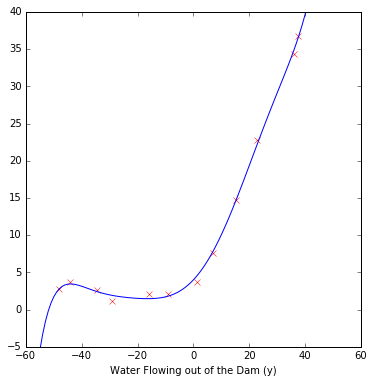

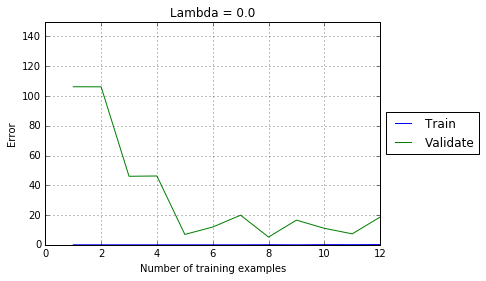

In [83]:
#Plot fit
plotFit(mean_v,std_v,param)

#Plot errors
polyXcv = getPolyX(Xcv,8)
Xcv_norm,_,_ = featureNormalize(polyXcv)

_,_ = getErrors(X_norm,y,Xcv_norm,ycv)

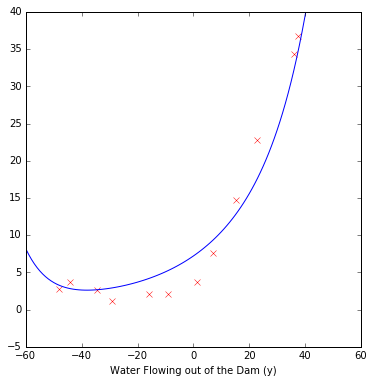

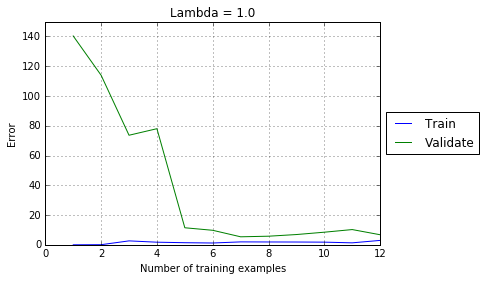

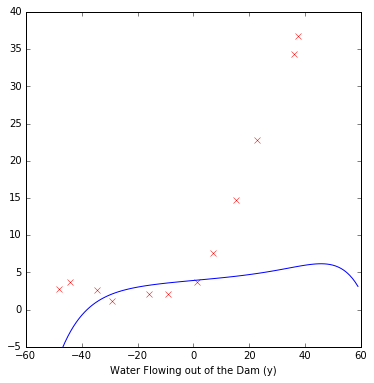

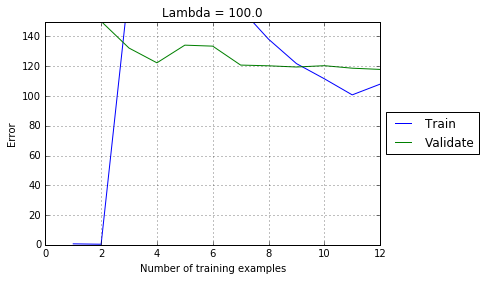

In [84]:
# Lambda = 1
itheta = np.ones((X_norm.shape[1],1))
ftheta = optimizeParams(itheta,X_norm,y,1.)
plotFit(mean_v,std_v,ftheta)
_,_ = getErrors(X_norm,y,Xcv_norm,ycv,1)

# Lambda = 100
itheta = np.ones((X_norm.shape[1],1))
ftheta = optimizeParams(itheta,X_norm,y,100.)
plotFit(mean_v,std_v,ftheta)
_,_ = getErrors(X_norm,y,Xcv_norm,ycv,100)

In [85]:
def validationCurve(x,y,xcv,ycv,lam_v):

    error_train = []
    error_val = [] 
    itheta = np.ones([x.shape[1],1])

    for l in lam_v: 
 
        param_v = optimizeParams(itheta,x,y,l)
        ftheta = param_v[0]
        costX  = param_v[1]
      
        error_train.append(costX)
        error_val.append(computeCost(ftheta,xcv,ycv,1))
    
    plt.figure()
    plt.plot(lam_v,error_train,'b-',label='Train')
    plt.plot(lam_v,error_val,'g-',label='Validate')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

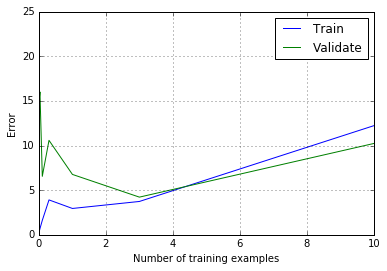

In [86]:
#Expect min at lambda approx 3.  See this
lam_v = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
validationCurve(X_norm,y,Xcv_norm,ycv,lam_v)

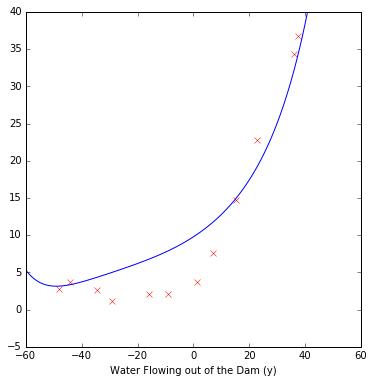

In [87]:
#Run on test set using recommended lambda value-- mine from above is
#close, but untuned
polyXtest = getPolyX(Xtest,8)
Xtest_norm, mean_v, std_v = featureNormalize(polyXtest)
itheta = np.ones((Xtest_norm.shape[1],1))
ftheta = optimizeParams(itheta,Xtest_norm,ytest,3.8599)
plotFit(mean_v,std_v,ftheta)

12


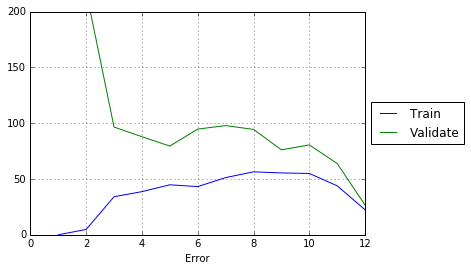

In [88]:
epochs = 50
error_train = []
error_val   = []
lam = 0.01

for j in xrange(1,len(X)+1): 
    
    eT, eV = 0., 0.
    for i in xrange(epochs):
       
        samp = random.sample(range(0,12), j)

        Xrand = [ X[k,:] for k in samp ] 
        Xrand = np.array([Xrand])[0]
        #print Xrand.shape
        
        yrand = [ y[k,:] for k in samp ] 
        yrand = np.array([yrand])[0]
        
        samp2 = random.sample(range(0,21), j)
        
        Xcv_rand = [ Xcv[k,:] for k in samp2 ] 
        Xcv_rand = np.array([Xcv_rand])[0]

        ycv_rand = [ ycv[k,:] for k in samp2 ] 
        ycv_rand = np.array([ycv_rand])[0]

        itheta = np.ones((Xrand.shape[1],1))
        param_v = optimizeParams(itheta,Xrand,yrand,lam)

        theta = param_v[0]
        
        eT += param_v[1]
        eV += computeCost(theta,Xcv_rand,ycv_rand,lam)
    
    error_train.append(float(eT)/epochs)
    error_val.append(float(eV)/epochs)
    
print len(error_train)
xit = np.arange(1,13)
  
# Hm doesn't quite match.  Errors are very high
plt.figure()
plt.plot(xit,error_train,'b-',label='Train')
plt.plot(xit,error_val,'g-',label='Validate')
plt.xlabel('Number of Training Samples')
plt.xlabel('Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,200)
plt.grid(True)